# DeepFake Detection Project

In [1]:
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import kaggle
import matplotlib.pyplot as plt

In [2]:
# --- 1. CONFIGURATION ---
DATASET_NAME = "ayushmandatta1/deepdetect-2025" 
DOWNLOAD_ROOT = "./deepdetect_data"
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# --- 2. DOWNLOAD DATASET ---
if not os.path.exists(DOWNLOAD_ROOT):
    print(f"Downloading {DATASET_NAME}...")
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(DATASET_NAME, path=DOWNLOAD_ROOT, unzip=True)
    print("Download complete.")
else:
    print("Dataset already downloaded.")

# --- 3. DATA PREPARATION (FIXED) ---
# Helper function to find the actual data folders if they are nested
def find_folder(root_dir, target_name):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if target_name in dirnames:
            return os.path.join(dirpath, target_name)
    raise FileNotFoundError(f"Could not find folder '{target_name}' inside {root_dir}")

# Locate the 'train' and 'test' folders automatically
try:
    TRAIN_PATH = find_folder(DOWNLOAD_ROOT, 'train')
    VAL_PATH = find_folder(DOWNLOAD_ROOT, 'test')
    print(f"Found Train Path: {TRAIN_PATH}")
    print(f"Found Test Path:  {VAL_PATH}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print(f"Current structure: {os.listdir(DOWNLOAD_ROOT)}")
    exit()



Using device: cuda
Dataset already downloaded.
Found Train Path: ./deepdetect_data\ddata\train
Found Test Path:  ./deepdetect_data\ddata\test


In [3]:
print('CUDA available:', torch.cuda.is_available()); print('CUDA version:', torch.version.cuda if torch.cuda.is_available() else 'N/A'); print('PyTorch version:', torch.__version__)

CUDA available: True
CUDA version: 12.8
PyTorch version: 2.11.0.dev20260117+cu128


In [ ]:
# Define Transforms (Resize to 224x224 for EfficientNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets specifically from their folders
train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=transform)
val_dataset = datasets.ImageFolder(root=VAL_PATH, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Classes: {train_dataset.classes}") # Should be ['Fake', 'Real']

# --- 4. BUILD MODEL (Transfer Learning) ---


# Load Pre-trained EfficientNet-B0
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze feature layers (We only want to train the classifier)
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier head
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2) # Output: 2 classes (Real/Fake)

model = model.to(DEVICE)

# --- 5. TRAINING LOOP WITH VALIDATION ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Starting training...")

for epoch in range(EPOCHS):
    # A. Training Phase
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_acc = 100 * train_correct / train_total

    # B. Validation Phase (The "Test" Check)
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_total
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {running_loss/len(train_loader):.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Acc: {val_acc:.2f}%")

# --- 6. SAVE MODEL ---
torch.save(model.state_dict(), "deepdetect_2025_model.pth")
print("Model saved successfully.")

Classes: ['fake', 'real']
Starting training...
Epoch [1/5] Train Loss: 0.4561 | Train Acc: 78.53% | Val Acc: 60.08%
Epoch [2/5] Train Loss: 0.4411 | Train Acc: 79.45% | Val Acc: 61.58%
Epoch [3/5] Train Loss: 0.4424 | Train Acc: 79.44% | Val Acc: 60.70%
Epoch [4/5] Train Loss: 0.4410 | Train Acc: 79.59% | Val Acc: 61.54%
Epoch [5/5] Train Loss: 0.4388 | Train Acc: 79.61% | Val Acc: 59.43%
Model saved successfully.


In [5]:
EPOCHS = 15
LEARNING_RATE = 0.0003
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DATA TRANSFORMS (AUGMENTATION ADDED) ---
# Training: Add noise/rotation to force the model to learn features, not pixels
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Validation: Clean, simple resize only (Simulates real world usage)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- 3. DATA LOADERS ---
train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(root=VAL_PATH, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Classes: {train_dataset.classes}")
print(f"Training on {len(train_dataset)} images, Validating on {len(val_dataset)} images.")

# --- 4. BUILD MODEL (FINE-TUNING) ---
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# A. Freeze the early layers (Generic features like edges/colors)
for param in model.features.parameters():
    param.requires_grad = False

# B. Unfreeze the last 20% of the network (Specific texture features)
# This allows the model to adapt to "Deepfake artifacts" specifically
for param in model.features[-3:]: 
    for p in param.parameters():
        p.requires_grad = True

# C. Replace Classifier Head with Dropout (Prevents Overfitting)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),  # Drop 40% of connections to prevent memorization
    nn.Linear(num_features, 2)
)

model = model.to(DEVICE)

# --- 5. OPTIMIZER & SCHEDULER ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Reduce LR if validation accuracy gets stuck for 2 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=2
)

# --- 6. TRAINING LOOP ---
best_val_acc = 0.0

print("Starting training with fine-tuning...")

for epoch in range(EPOCHS):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_acc = 100 * train_correct / train_total
    avg_train_loss = running_loss / len(train_loader)

    # --- VALIDATE ---
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_total
    
    # Update Learning Rate Scheduler
    scheduler.step(val_acc)
    
    # Print Stats
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Acc: {val_acc:.2f}%")
    
    # Save Best Model Only
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "deepdetect_best.pth")
        print(f"--> Best model saved! ({val_acc:.2f}%)")

print("Training Complete.")

Classes: ['fake', 'real']
Training on 90409 images, Validating on 21776 images.
Starting training with fine-tuning...
Epoch [1/15] Loss: 0.1901 | Train Acc: 92.21% | Val Acc: 60.80%
--> Best model saved! (60.80%)
Epoch [2/15] Loss: 0.0923 | Train Acc: 96.53% | Val Acc: 66.48%
--> Best model saved! (66.48%)
Epoch [3/15] Loss: 0.0640 | Train Acc: 97.65% | Val Acc: 60.88%


KeyboardInterrupt: 

In [6]:
# --- 1. CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32
WARMUP_EPOCHS = 5      # Phase 1: Train classifier only
FINETUNE_EPOCHS = 10   # Phase 2: Train backbone + classifier
TOTAL_EPOCHS = WARMUP_EPOCHS + FINETUNE_EPOCHS

# --- 2. STRONG AUGMENTATION (REGULARIZATION) ---
# Deepfake detection requires robustness to quality loss and slight geometry changes.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    
    # Geometric Augmentations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Simulate slight camera shifts
    
    # Quality/Color Augmentations (Crucial for Deepfakes)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # Simulate blur/compression artifacts
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- 3. DATA LOADERS ---
train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(root=VAL_PATH, transform=val_transform)

# num_workers=0 avoids Windows/VSCode freeze issues
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Classes: {train_dataset.classes}")

# --- 4. MODEL SETUP ---
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# A. INITIAL FREEZE: Freeze EVERYTHING first
for param in model.parameters():
    param.requires_grad = False

# B. MODIFY CLASSIFIER: High Dropout as requested (0.4 - 0.5)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5), # Stronger dropout
    nn.Linear(num_features, 2)
)

model = model.to(DEVICE)

# --- 5. LOSS FUNCTION (With Label Smoothing) ---
# Label smoothing prevents the model from being "too confident" (overfitting)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# --- HELPER FUNCTION FOR TRAINING ---
def train_one_epoch(model, loader, optimizer, phase_name):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    acc = 100 * correct / total
    avg_loss = running_loss / len(loader)
    return avg_loss, acc

def validate(model, loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate val loss too
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    acc = 100 * correct / total
    avg_loss = val_loss / len(loader)
    return avg_loss, acc

# --- 6. PHASE 1: WARMUP (Classifier Only) ---
print(f"\n=== PHASE 1: WARMUP ({WARMUP_EPOCHS} Epochs) ===")
print("Only training the classifier head. Feature extractor is frozen.")

# Optimizer for Phase 1: Only optimize the classifier parameters
optimizer_warmup = optim.Adam(model.classifier.parameters(), lr=1e-3)

for epoch in range(WARMUP_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer_warmup, "Warmup")
    val_loss, val_acc = validate(model, val_loader)
    
    print(f"Epoch [{epoch+1}/{WARMUP_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

print("\n--> Phase 1 Complete. Model head is initialized.")

# --- 7. PHASE 2: FINE-TUNING (Partial Unfreeze) ---
print(f"\n=== PHASE 2: FINE-TUNING ({FINETUNE_EPOCHS} Epochs) ===")
print("Unfreezing last 2 blocks of EfficientNet. Using differential learning rates.")

# A. Unfreeze the last 2 feature blocks (EfficientNet specific)
# model.features is a sequence of blocks. We unfreeze the last few.
for param in model.features[-2:].parameters():
    param.requires_grad = True

# B. Differential Learning Rate:
# - Low LR (1e-4) for the backbone (to preserve ImageNet features)
# - High LR (1e-3) for the classifier (to keep learning fast)
optimizer_finetune = optim.Adam([
    {'params': model.features[-2:].parameters(), 'lr': 1e-4}, # Backbone
    {'params': model.classifier.parameters(), 'lr': 1e-3}     # Head
], weight_decay=1e-4) # Added weight decay for regularization

# Scheduler for Phase 2
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_finetune, mode='max', factor=0.1, patience=2)

best_acc = 0.0

for epoch in range(FINETUNE_EPOCHS):
    current_epoch = epoch + 1 + WARMUP_EPOCHS
    
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer_finetune, "FineTune")
    val_loss, val_acc = validate(model, val_loader)
    
    scheduler.step(val_acc)
    
    print(f"Epoch [{current_epoch}/{TOTAL_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "deepdetect_robust_best.pth")
        print(f"--> Best model saved! ({best_acc:.2f}%)")

print("\nFull training complete.")

Classes: ['fake', 'real']

=== PHASE 1: WARMUP (5 Epochs) ===
Only training the classifier head. Feature extractor is frozen.
Epoch [1/5] Train Loss: 0.6133 Acc: 68.99% | Val Loss: 0.5229 Acc: 79.62%
Epoch [2/5] Train Loss: 0.6112 Acc: 69.37% | Val Loss: 0.5318 Acc: 78.15%
Epoch [3/5] Train Loss: 0.6119 Acc: 69.30% | Val Loss: 0.4887 Acc: 83.12%
Epoch [4/5] Train Loss: 0.6118 Acc: 69.24% | Val Loss: 0.5311 Acc: 77.81%
Epoch [5/5] Train Loss: 0.6113 Acc: 69.21% | Val Loss: 0.4880 Acc: 83.33%

--> Phase 1 Complete. Model head is initialized.

=== PHASE 2: FINE-TUNING (10 Epochs) ===
Unfreezing last 2 blocks of EfficientNet. Using differential learning rates.
Epoch [6/15] Train Loss: 0.5122 Acc: 78.36% | Val Loss: 0.3849 Acc: 89.68%
--> Best model saved! (89.68%)
Epoch [7/15] Train Loss: 0.4469 Acc: 83.79% | Val Loss: 0.3954 Acc: 88.65%
Epoch [8/15] Train Loss: 0.4171 Acc: 86.16% | Val Loss: 0.4136 Acc: 87.45%
Epoch [9/15] Train Loss: 0.3990 Acc: 87.56% | Val Loss: 0.3994 Acc: 88.34%
Epoc

Using device: cuda
Classes: ['fake', 'real']
Loading EfficientNet-B2...
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\andre/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:03<00:00, 10.5MB/s]



=== PHASE 1: WARMUP (5 Epochs) ===
Only training the classifier head. Feature extractor is frozen.
Epoch [1/5] Train Loss: 0.5990 Acc: 70.32% | Val Loss: 0.5844 Acc: 70.40%
Epoch [2/5] Train Loss: 0.5950 Acc: 70.87% | Val Loss: 0.5536 Acc: 74.29%
Epoch [3/5] Train Loss: 0.5918 Acc: 71.22% | Val Loss: 0.6000 Acc: 69.17%
Epoch [4/5] Train Loss: 0.5923 Acc: 71.28% | Val Loss: 0.5564 Acc: 73.83%
Epoch [5/5] Train Loss: 0.5931 Acc: 71.08% | Val Loss: 0.5839 Acc: 70.88%

--> Phase 1 Complete. Model head is initialized.

=== PHASE 2: FINE-TUNING (10 Epochs) ===
Unfreezing last 2 blocks of EfficientNet. Using differential learning rates.
Epoch [6/15] Train Loss: 0.4460 Acc: 83.77% | Val Loss: 0.3644 Acc: 90.58%
--> Best model saved! (90.58%)
Epoch [7/15] Train Loss: 0.3701 Acc: 89.55% | Val Loss: 0.3557 Acc: 91.66%
--> Best model saved! (91.66%)
Epoch [8/15] Train Loss: 0.3414 Acc: 91.52% | Val Loss: 0.3609 Acc: 90.43%
--> Early Stopping Counter: 1/3
Epoch [9/15] Train Loss: 0.3266 Acc: 92.50

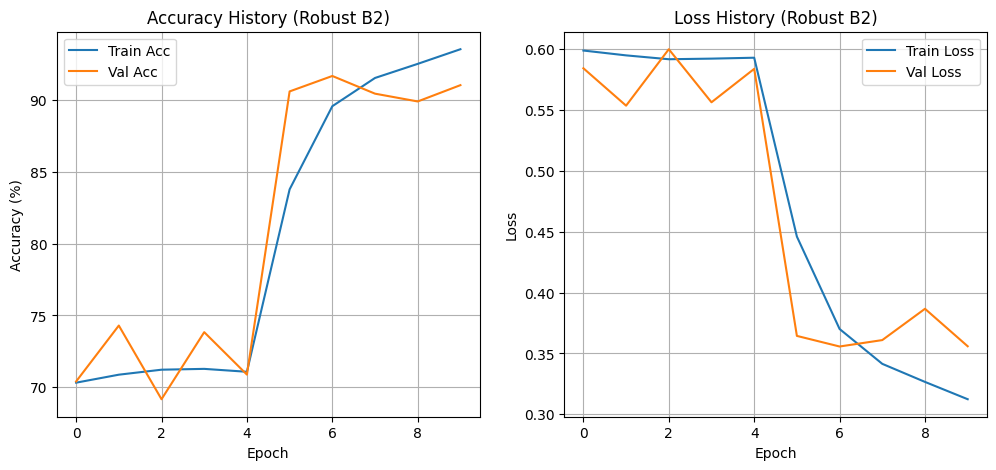

In [4]:
# --- 1. CONFIGURATION ---
DATASET_NAME = "ayushmandatta1/deepdetect-2025" 
DOWNLOAD_ROOT = "./deepdetect_data"
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 32
WARMUP_EPOCHS = 5      # Phase 1: Train classifier only
FINETUNE_EPOCHS = 10   # Phase 2: Train backbone + classifier
TOTAL_EPOCHS = WARMUP_EPOCHS + FINETUNE_EPOCHS

# --- 2. STRONG AUGMENTATION (REGULARIZATION) ---
# Deepfake detection requires robustness to quality loss and slight geometry changes.
train_transform = transforms.Compose([
    transforms.Resize((260, 260)), # B2 Input Size
    
    # Geometric Augmentations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Simulate slight camera shifts
    
    # Quality/Color Augmentations (Crucial for Deepfakes)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # Simulate blur/compression artifacts
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((260, 260)), # B2 Input Size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(root=VAL_PATH, transform=val_transform)

# num_workers=0 avoids Windows/VSCode freeze issues
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Classes: {train_dataset.classes}")

# --- 4. MODEL SETUP ---
print("Loading EfficientNet-B2...")
model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)

# A. INITIAL FREEZE: Freeze EVERYTHING first
for param in model.parameters():
    param.requires_grad = False

# B. MODIFY CLASSIFIER: High Dropout as requested (0.4 - 0.5)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5), # Stronger dropout
    nn.Linear(num_features, 2)
)

model = model.to(DEVICE)

# --- 5. LOSS FUNCTION (With Label Smoothing) ---
# Label smoothing prevents the model from being "too confident" (overfitting)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# --- HELPER FUNCTION FOR TRAINING ---
def train_one_epoch(model, loader, optimizer, phase_name):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    acc = 100 * correct / total
    avg_loss = running_loss / len(loader)
    return avg_loss, acc

def validate(model, loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate val loss too
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    acc = 100 * correct / total
    avg_loss = val_loss / len(loader)
    return avg_loss, acc

# --- 6. PHASE 1: WARMUP (Classifier Only) ---
print(f"\n=== PHASE 1: WARMUP ({WARMUP_EPOCHS} Epochs) ===")
print("Only training the classifier head. Feature extractor is frozen.")

# Optimizer for Phase 1: Only optimize the classifier parameters
optimizer_warmup = optim.Adam(model.classifier.parameters(), lr=1e-3)

# History Tracking
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(WARMUP_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer_warmup, "Warmup")
    val_loss, val_acc = validate(model, val_loader)
    
    # Update History
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{WARMUP_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

print("\n--> Phase 1 Complete. Model head is initialized.")

# --- 7. PHASE 2: FINE-TUNING (Partial Unfreeze) ---
print(f"\n=== PHASE 2: FINE-TUNING ({FINETUNE_EPOCHS} Epochs) ===")
print("Unfreezing last 2 blocks of EfficientNet. Using differential learning rates.")

# A. Unfreeze the last 2 feature blocks (EfficientNet specific)
# model.features is a sequence of blocks. We unfreeze the last few.
for param in model.features[-2:].parameters():
    param.requires_grad = True

# B. Differential Learning Rate:
# - Low LR (1e-4) for the backbone (to preserve ImageNet features)
# - High LR (1e-3) for the classifier (to keep learning fast)
optimizer_finetune = optim.Adam([
    {'params': model.features[-2:].parameters(), 'lr': 1e-4}, # Backbone
    {'params': model.classifier.parameters(), 'lr': 1e-3}     # Head
], weight_decay=1e-4) # Added weight decay for regularization

# Scheduler for Phase 2
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_finetune, mode='max', factor=0.1, patience=2)

best_acc = 0.0
patience_counter = 0
EARLY_STOPPING_PATIENCE = 3

for epoch in range(FINETUNE_EPOCHS):
    current_epoch = epoch + 1 + WARMUP_EPOCHS
    
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer_finetune, "FineTune")
    val_loss, val_acc = validate(model, val_loader)
    
    # Update History
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    scheduler.step(val_acc)
    
    print(f"Epoch [{current_epoch}/{TOTAL_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")
    
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "deepdetect_robust_best.pth")
        print(f"--> Best model saved! ({best_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"--> Early Stopping Counter: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break

print("\nFull training complete.")

# --- 8. PLOTTING ---
try:
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Train Acc')
    plt.plot(val_acc_history, label='Val Acc')
    plt.title('Accuracy History (Robust B2)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.title('Loss History (Robust B2)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.savefig('training_curves_robust_b2.png')
    print("Curves saved to training_curves_robust_b2.png")
except Exception as e:
    print(f"Error plotting curves: {e}")